# Real-time risk with atoti

## Introduction

In our example we will create a real-time risk dashboard using atoti.

We will consolidate various sensitivities for an equity options portfolio as a data example. We are going to simulate a live feed of market quotes and use QuantLib to recalculate sensitivities on the fly, stream updated risk numbers to an atoti-powered in-memory cube which will update our risk dashboard.

Have a look at the GIF of the running atoti application below. On the left, we have a real-time market data feed which is a replay of historical stock prices. On the bottom, there are our trades and on the right, we have risk data continuously re-calculated and re-aggregated at various levels. Every time market data is updated, a chain of actions is performed automatically, resulting in an update to the risk summary table. With this in mind, let’s dive deep into the details!

<img src="./app-preview.gif" alt="Real-time risk app preview" width="100%">

# Imports

In [1]:
import time
from datetime import datetime, timedelta
import pandas as pd

# atoti session

The first step is to create atoti session for an in-memory data cube:

In [2]:
import atoti as tt

from atoti.config import create_config

config = create_config(
    metadata_db="./metadata.db", max_memory="8G", sampling_mode=tt.sampling.FULL
)
session = tt.create_session(config=config)

Welcome to atoti 0.4.2.20200617181308!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


# atoti for real-time update

As we discussed, we have two live feeds in our app - a market data feed simulating the tick stock price time-series which is then producing a feed of risk numbers by recalculating option greeks with a Quantlib function. You can easily replace them with your own real time data sources - for example, live trade feeds, sensitivity updates, stress-testing numbers, etc. 

atoti provides **multiple ways to implement real-time update**: 

- the first is by using the reactive datastores - it tells atoti to observe a file or a folder and fetch updates as soon as there are any, 
- the second is the “append” command that pushes new data into a data store forcing re-calculation. Both methods are illustrated below,
- please refer to the documentation to read about other methods, such as listening to a [kafka feed](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=kafka#atoti.store.Store.load_kafka).

**Data visualization** in the atoti app supports the “continuous queries” feature, enabling widgets to automatically refresh the results every time a single contribution changes in the data store. You can toggle between “Turn on real-time”, “Refresh periodically” and “Pause query” for each widget in the atoti app, as shown in this picture:


<img src="./widget-query-mode.png" alt="Widget query mode" width="70%">

To access atoti dashboards open this URL:

In [3]:
session.url

'http://localhost:56539'

# atoti data cube

Let's create a cube with two datastores: one for the market data and one for the risk metrics. 

atoti provides two methods for the real-time update: the first is by using the reactive datastores - it tells atoti to observe a file or a folder and fetch updates as soon as there are any, and the second is the “append” command that pushes new data into a data store forcing re-calculation. 

We are creating the `sensitivity_store` and connecting it to a source, in our case a csv file on disc, by setting the parameter `watch` to `True`:

In [4]:
sensitivities_store = session.read_csv(
    "risk_data.csv",
    keys=["AsOfDate", "TradeId", "RiskFactor"],
    store_name="Sensitivities",
    types={"TradeId": tt.types.STRING, "AsOfDate": tt.types.LOCAL_DATE},
    watch=True, 
)

The parameter `watch = True` makes the `sensitivities_store` fetch the updates from the file on the disk automatically when it changes. The parameter `watch` is available for `read_csv` and `read_parquet` functions, as described in the atoti [doc](https://docs.atoti.io/0.4.1/lib/atoti.html?highlight=watch#atoti.session.Session.read_csv).


To implement real-time instrument prices, we’ll be pushing new values using the datastore `append` command. In the following cell, we're creating the `market_data_store`. As you probably noticed, we are not setting the `watch` parameter as in the previous example, as it defaults to `False`:

In [5]:
market_data_store = session.read_csv(
    "market_data.csv",
    keys=["AsOfDate", "Instrument"],
    store_name="Market Data Store",
    types={
        "AsOfDate": tt.types.LOCAL_DATE,
        "Instrument": tt.types.STRING,
        "Quote": tt.types.DOUBLE,
    },
)

At any time, we can use the `append` command to inject new records, for example:

In [6]:
market_data_store.append(("2020-05-01", "AAPL", 310.0))
market_data_store.head(5)

Quote
AsOfDate   Instrument            
2020-07-08 OXY          17.239901
           MSFT        215.589996
           AAPL        383.820007
2020-05-01 AAPL        310.000000

This `join` will link the `sensitivities_store` and the `market_data_store` and allow displaying sensitivities next to quotes.

In [7]:
sensitivities_store.join(
    market_data_store, mapping={"AsOfDate": "AsOfDate", "RiskFactor": "Instrument"}
)

Finally, we need to run the `create_cube` command.

In [8]:
cube = session.create_cube(sensitivities_store, "Sensitivities")

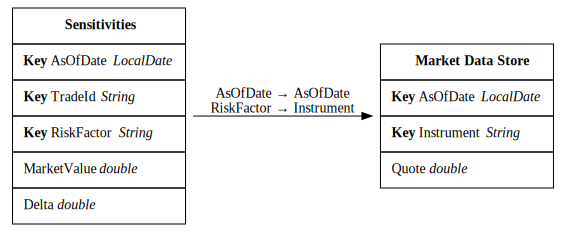

In [9]:
cube.schema

We can start exploring the data in the cube. The following command serves for a quick inline atoti visualization:

In [11]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Refining the cube

The `create_cube` command triggered the creation of default measures and dimensions, which can be further customized and refined, we are creating variables to access their collections:

In [11]:
m = cube.measures
lvl = cube.levels
h = cube.hierarchies

The following cell **hides the created measures** for the mean:

In [12]:
m["MarketValue.MEAN"].visible = False
m["Delta.MEAN"].visible = False

The next cell is making the date dimension slicing, so that there's no summation across dates:

In [13]:
# TODO: why am I getting UI error "c is undefined":

In [14]:
h["AsOfDate"].slicing = True

The next cell will sort dates in desc order:

In [15]:
lvl["AsOfDate"].comparator = tt.comparator.DESC

Please refer to the atoti documentation to learn about other ways to refine your cube, in particular about creating custom aggregation functions: [New measures](https://docs.atoti.io/0.4.1/tutorial/01-Basics.html#New-measures).

# Enriching risk data - trade attributes and multi-level book structure

To facilitate the analysis, we can enrich the metrics with additional attributes such as risk factors, regions, sectors, trade typologies, etc. 

In this example, we are adding trade attribute data and linking trades to a multi-level booking hierarchy. 

In [16]:
trade_attributes = session.read_csv(
    "trade_attributes.csv",
    types={"TradeId": tt.types.STRING, "Strike": tt.types.STRING},
    keys=["TradeId"],
    store_name="Trade Attributes",
)

sensitivities_store.join(trade_attributes)

In [17]:
book_hierarchy = session.read_pandas(
    pd.DataFrame(
        data={
            "Book": [
                "EQ_VOL_HED",
                "EQ_STRUCT",
                "EQ_LARG_DM",
                "EQ_WAREHOU",
                "EQ_SMAL_EM",
            ],
            "Desk": [
                "Structuring",
                "Structuring",
                "Equity Trading",
                "Equity Trading",
                "Equity Trading",
            ],
            "Business Unit": [
                "Equities",
                "Equities",
                "Equities",
                "Equities",
                "Equities",
            ],
        }
    ),
    keys=["Book"],
    store_name="Book Hierarchy",
)

trade_attributes.join(book_hierarchy)

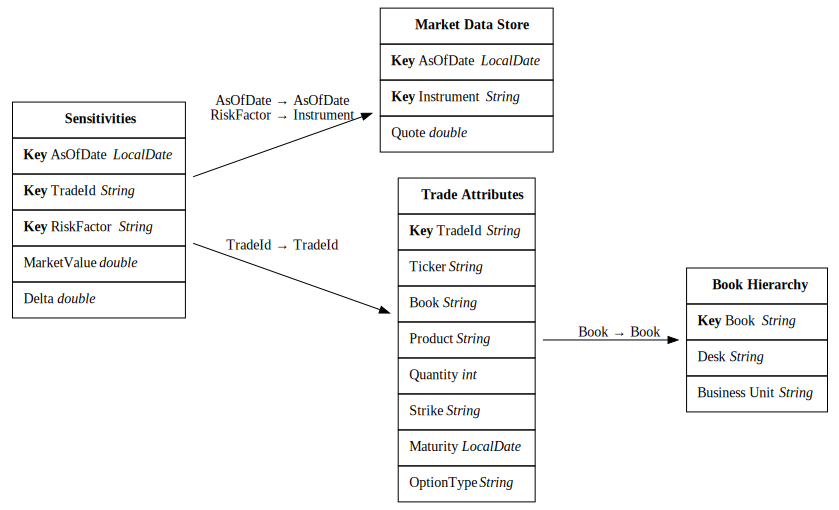

In [18]:
cube.schema

In fact, the **attributes do not have to be static**. They can be refreshed as soon as data arrives. For example, by adding a “Trade status” into the `trade_attributes` store I could use it to tag trades as “Terminated” and filter them out from the view.

In the following cell, we are creating a hierarchy representing ogranisational structure:

In [19]:
h["Portfolio Structure"] = {
    "Business Unit": lvl["Business Unit"],
    "Desk": lvl["Desk"],
    "Book": lvl["Book"],
}

We can expand and collapse data along the multi-level hierarchy:

In [21]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Start real-time sources

In the following section I'm emulating a market data feed, which is triggering portfolio repricing. 

A real pricing library is mocked up by a function computing greeks using a QuantLib implementation of the Black-Scholes formulae. 

In [22]:
from pricing_engine_emulator import reprice_trade, reprice_portfolio

Open a dashboard via this link - you will see the most recent portfolio summary. The widgets are switched to the "real-time" query mode, but the data is not updating just yet. 

In [24]:
session.url + "/#/dashboard/8b4"

'http://localhost:56539/#/dashboard/8b4'

To simulate the market data updates, I am going to replay historical stock prices available from Yahoo Finance. This code snippet downloads historical data and pushes new tick updates into a queue. The publisher waits for the `should_publish` event, which is triggered in the subsequent cells.

In [25]:
import threading, queue

should_publish = threading.Event()

spot_update_queue = queue.Queue()
tick_data = pd.read_csv(
    "stock_price_tick_data.csv", index_col="AsOfDate", parse_dates=["AsOfDate"]
)
positions = pd.read_csv("trade_attributes.csv", parse_dates=["Maturity"])


def start_spot_publisher():
    # The publisher is replaying tick_data.
    # It waits for the should publish event.
    
    current_time = -1
    for idx, row in tick_data.iterrows():
        next_time = idx
        if current_time != -1:
            dt = (next_time - current_time).total_seconds() / 100.0
            time.sleep(dt)
        current_time = idx
        print("\rawaiting for publishing update " + str(idx), end='')        
        should_publish.wait()
        print("\rpublishing update " + str(idx), end='')        
        spot_update_queue.put((idx, row.to_dict()))
    spot_update_queue.join()
    print("All work completed")


def start_spot_update_listener():
    print("Real time updates started")
    while True:
        calc_date, spot_prices_by_ticker = spot_update_queue.get()

        """
        As discussed above, I'm illustrating the "reactive" data store 
        by configuring it with the parameter watch set to True.
        With the following code I'm updating the file on disc:
        """
        reprice_portfolio(spot_prices_by_ticker, positions, calc_date).to_csv(
            "risk_data.csv", index=False
        )

        """
        The second example of real-time implementation - is injecting the data 
        directly into a datastore.
        With the following code I'm appending the new stock prices to the market data store.
        """
        for i in list(spot_prices_by_ticker.items()):
            if not pd.isnull(i[1]):
                print((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))
                market_data_store.append((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))

        spot_update_queue.task_done()


listener_thread = threading.Thread(target=start_spot_update_listener, daemon=True)
publisher_thread = threading.Thread(target=start_spot_publisher, daemon=True)


Run the next cell to start the real-time feeds - and see the cells in the dashboards blinking if then contributing data changes.

In [ ]:
publisher_thread.start()
listener_thread.start()
# start publishing
should_publish.set()

In [ ]:
# pause publishing
should_publish.clear()